In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [103]:
# read in data set
df = pd.read_csv('./data/combined-data.csv')
df.dtypes

Id               object
Shape            object
Weight          float64
Clarity          object
Colour           object
Cut              object
Polish           object
Symmetry         object
Fluorescence     object
Measurements     object
Price           float64
Data Url         object
dtype: object

In [79]:
'''
Steps to clean data:

1) Check if all data types are as they should be.
2) Check if any missing values in the 4 C's of diamond grading (Those determine the price more than any other factor).
3) If any missing values in the 4 C's, delete those rows
'''

"\nSteps to clean data:\n\n1) Check if all data types are as they should be.\n2) Check if any missing values in the 4 C's of diamond grading (Those determine the price more than any other factor).\n3) If any missing values in the 4 C's, delete those rows\n"

In [104]:
df.isnull().sum()

Id                 0
Shape              0
Weight             0
Clarity           25
Colour             0
Cut                2
Polish             1
Symmetry           7
Fluorescence       2
Measurements       0
Price              0
Data Url        6271
dtype: int64

In [105]:
# drop the rows with missing values in these columns
df = df.dropna(subset = ['Clarity', 'Cut'])
df.isnull().sum()

Id                 0
Shape              0
Weight             0
Clarity            0
Colour             0
Cut                0
Polish             0
Symmetry           6
Fluorescence       0
Measurements       0
Price              0
Data Url        6249
dtype: int64

In [12]:
'''
Explore the questions of: Does a certain shape of diamond cost more than another?
Grab diamonds of same carat to compare value in different shapes
'''

In [106]:
# check most occuring weight of diamonds in dataset
df['Weight'].value_counts()

0.50    1999
0.30    1332
0.23    1029
0.40     385
0.31     326
        ... 
2.33       1
0.99       1
2.36       1
1.46       1
0.64       1
Name: Weight, Length: 181, dtype: int64

In [107]:
# grab diamonds that weigh half a carat
hlf_crt = df[df['Weight'] == 0.5]
shapes = ['ROUND', 'HEART', 'PRINCESS', 'OVAL', 'EMERALD', 'CUSHION', 'PEAR']
means = []
num_sold = []
# calculate mean and number of units sold for each shape
for cut in shapes:
    tmp_df = hlf_crt[hlf_crt['Shape'] == cut]
    means.append(tmp_df['Price'].mean())
    num_sold.append(len(tmp_df['Price']))
print(means)
print(num_sold)

[2012.1738067226868, 1009.5, 1544.6814090909093, 1586.6120477815705, 1331.709, 1348.5450289017335, 1987.5276190476195]
[1190, 11, 220, 293, 70, 173, 42]


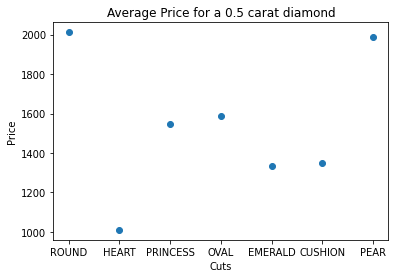

In [108]:
# plot average price for each shape of diamond
plt.scatter(shapes, means)
plt.xlabel("Cuts")
plt.ylabel("Price")
plt.title("Average Price for a 0.5 carat diamond")
plt.show()

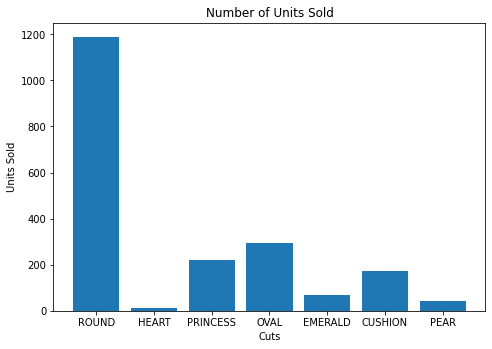

In [109]:
# plot number of units sold for each shape, to see if demand influences price
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(shapes, num_sold)
plt.xlabel("Cuts")
plt.ylabel("Units Sold")
plt.title("Number of Units Sold")
plt.show()

In [ ]:
'''
Exploring the question: How much do the 4 C's affect the price of a diamond?

1) No need to worry about cut quality because any diamond being sold as an engagement ring
   will have a cut quality of VG or EX. Jewelry stores or custom designers will literally refuse to
   sell anything less than those two.
'''

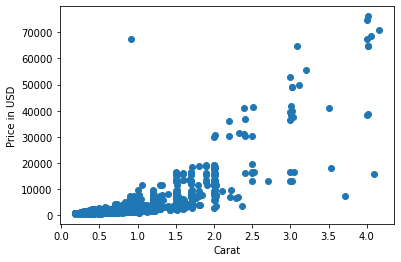

In [110]:
# show the general pattern for carat price influence (exponential)
sorted_df = df.sort_values(by=['Weight'])
sorted_df = sorted_df[sorted_df['Weight'] < 5]
plt.scatter(list(sorted_df['Weight']), list(sorted_df['Price']))
plt.xlabel("Carat")
plt.ylabel("Price in USD")
plt.show()

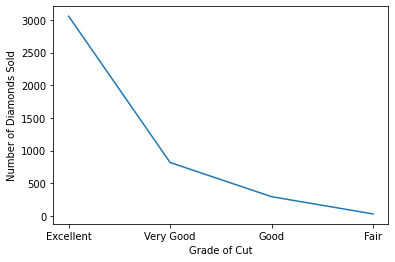

In [111]:
# Find how many diamonds of poor cut quality get sold
round_df = df[df['Shape'] == 'ROUND']
cut_grades = ['Excellent', 'Very Good', 'Good', 'Fair']
values = list(round_df['Cut'].value_counts())
plt.plot(cut_grades, values)
plt.ylabel("Number of Diamonds Sold")
plt.xlabel("Grade of Cut")
plt.show()

In [ ]:
'''
Find influence of prices for color and clarity by comparing diamonds with similar characteristics.
'''

In [112]:
round_df = round_df[round_df['Weight'] == 0.5]
bad_color_df = round_df[round_df['Colour'] == 'S-T']
bad_color = bad_color_df['Price'].mean()

In [113]:
bad_c = round_df[round_df['Clarity'] == 'I1']
bad_clarity_df = bad_c[bad_c['Colour'] == 'G']
bad_clarity = bad_clarity_df['Price'].mean()

In [115]:
round_df = round_df[round_df['Clarity'] == 'VS1']
round_df = round_df[round_df['Colour'] == 'G']
good_diamond = round_df['Price'].mean()

Text(0, 0.5, 'Price USD')

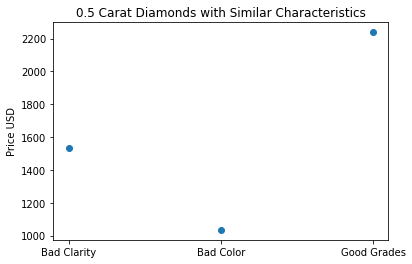

In [119]:
plt.scatter(['Bad Clarity', 'Bad Color', 'Good Grades'], [bad_clarity, bad_color, good_diamond])
plt.title('0.5 Carat Diamonds with Similar Characteristics')
plt.ylabel('Price USD')

In [ ]:
'''
Exploring the third question: Is it possible to know if you're getting a good price?

Plan: Create a basic linear regression model. Based on the data given (weighed mostly the 4 C's),
      it will predict the price of a diamond.
      
      Since most engagement rings are round diamonds we will focus on those.

'''

In [120]:
round_df = df[df['Shape'] == 'ROUND']
y = round_df['Price']
# drop unneccesary data
round_df = round_df.drop(['Id', 'Shape', 'Price', 'Data Url', 'Measurements'], axis=1)

In [121]:
# create dummy variables for categorical data
cat_cols = round_df.select_dtypes(include=['object']).copy().columns
for var in cat_cols:
    round_df = pd.concat([round_df.drop(var, axis=1), pd.get_dummies(round_df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
X = round_df

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42) #split data into train/test
lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

# Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print('The r-squared on the training data was', train_score)
print('The r-squared on the test data was', test_score)

The r-squared on the training data was 0.9214381403911955
The r-squared on the test data was 0.9367783926755183
